# GSE75748 filtering and fitting

We already have the Spearman coefficient matrix for the 162-sample study. After imputation, it only has 22,930 genes remain, with the others actually not expressing (originally more than 60,000 genes).

With that in mind we have around 400,000,000 gene pairs. The correlation coefficient cutoff is set 0.85. How many gene pairs are considered correlated?

## Filtering

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import time
from sklearn.neighbors import LocalOutlierFactor

import sys
sys.path.append("../")
from biologiclib.modelBase import *
from biologiclib.plotUtils import *
from biologiclib.inference import *
from rm_outlier import *
%matplotlib inline

In [2]:
# load spearman correlation matrix
#h9_spearman_corr = pd.read_csv("~/Storage/graduation_project/GSE75748/h9_spearman_corr.tsv")
h9_spearman_corr = pd.read_csv("C:/Users/rainl/vm-storage/graduation_project/GSE75748/h9_spearman_corr.tsv", 
                               sep = "\t", index_col = 0)
h9_spearman_corr.head()

,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,ENSG00000001460.17,ENSG00000001461.16,...,ENSG00000282988.1,ENSG00000283013.1,ENSG00000283036.1,ENSG00000283041.1,ENSG00000283045.1,ENSG00000283050.1,ENSG00000283051.1,ENSG00000283064.1,ENSG00000283098.1,ENSG00000283103.1
ENSG00000000003.14,1.000000,0.066396,0.070206,0.011653,-0.005721,0.018786,0.000440,-0.052862,0.126178,0.055717,...,0.182360,-0.024983,-0.021043,0.197593,0.046657,0.075704,-0.029964,-0.046830,0.088553,0.210005
ENSG00000000005.5,0.066396,1.000000,-0.001656,-0.048184,0.011303,-0.016304,0.102233,-0.018085,-0.094103,0.152605,...,-0.102707,-0.185696,-0.137568,0.034440,-0.040859,0.069326,-0.183974,0.209683,-0.101369,-0.018576
ENSG00000000419.12,0.070206,-0.001656,1.000000,-0.124372,-0.013447,-0.063406,0.110461,0.057040,0.102308,-0.052131,...,-0.126147,0.176552,-0.024802,0.058390,0.166198,0.085874,-0.047075,-0.085530,-0.028783,-0.051301
ENSG00000000457.13,0.011653,-0.048184,-0.124372,1.000000,0.026235,-0.042422,0.055772,0.023712,0.093345,-0.052375,...,0.099081,0.119142,0.160668,-0.154965,-0.045885,0.094309,0.189544,0.109012,0.142999,-0.009824
ENSG00000000460.16,-0.005721,0.011303,-0.013447,0.026235,1.000000,0.033001,0.004608,0.060428,0.035537,-0.041458,...,-0.021442,-0.031752,0.073332,0.005484,0.098675,-0.027430,0.069820,-0.037340,0.014165,0.024618


In [3]:
THRESHOLD = 0.85

# exclude diagnal elements
row_indices_all, col_indices_all = np.where((h9_spearman_corr > 0.85) & (h9_spearman_corr < 1.0 - 1E-10))
filtered_indices = list(zip(row_indices_all, col_indices_all))

print(int(len(filtered_indices) / 2), "pairs of genes are considered correlated")

36661 pairs of genes are considered correlated


Around 1/10,000 pairs are considered as correlated, which makes sense and offers a good start point to fit them to logic gates. But, before that, we want to plot some out to gain some intuition

In [4]:
# load expression matrix
h9_tpm = pd.read_csv("C:/Users/rainl/vm-storage/graduation_project/GSE75748/h9_imputed.tsv",
                    sep = "\t", index_col = 0)
h9_tpm.head()

,SRR2977655,SRR2977656,SRR2977657,SRR2977658,SRR2977659,SRR2977660,SRR2977661,SRR2977662,SRR2977663,SRR2977664,...,SRR2977807,SRR2977808,SRR2977809,SRR2977810,SRR2977811,SRR2977812,SRR2977813,SRR2977814,SRR2977815,SRR2977816
ENSG00000000003.14,5.333434,5.401781,5.770235,4.661787,6.163233,5.538727,5.245607,5.342846,5.332342,4.015143,...,5.051099,5.530516,3.392994,5.732665,5.679862,5.603962,5.248733,5.265112,5.444956,3.658732
ENSG00000000005.5,0.405174,1.249968,0.382527,0.368489,0.392334,0.368489,1.645401,0.405174,0.504082,3.131879,...,0.535048,0.719265,0.152943,3.743526,0.602072,3.538463,0.656286,0.690559,3.039113,0.749957
ENSG00000000419.12,4.204045,3.092342,4.310163,4.536766,4.014042,3.381379,4.406172,4.118315,3.951724,3.695306,...,4.643275,3.100543,5.333091,3.417602,4.386976,4.655274,3.856929,4.388999,2.256160,3.578839
ENSG00000000457.13,1.803950,1.249416,0.319675,2.135601,0.757774,2.427578,1.309815,1.590746,3.693367,3.055467,...,3.639198,1.283812,0.285568,0.113242,0.137654,0.535571,3.729450,0.213661,5.374394,0.170811
ENSG00000000460.16,3.753187,0.244273,0.172557,4.943733,4.321864,4.409670,3.152386,3.976263,2.295498,4.773156,...,3.844763,0.964174,4.893142,4.961760,2.728839,4.073061,2.138180,4.200864,3.579143,2.512359


In [5]:
# def remove_outliers_2d(X, Y):
#     X, Y = np.array(X), np.array(Y)
#     D = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
#     lof = LocalOutlierFactor(n_neighbors = 100, contamination = 0.1)
#     is_outlier = lof.fit_predict(D) == -1
#     new_X, new_Y = X[~is_outlier], Y[~is_outlier]
#     return new_X, new_Y

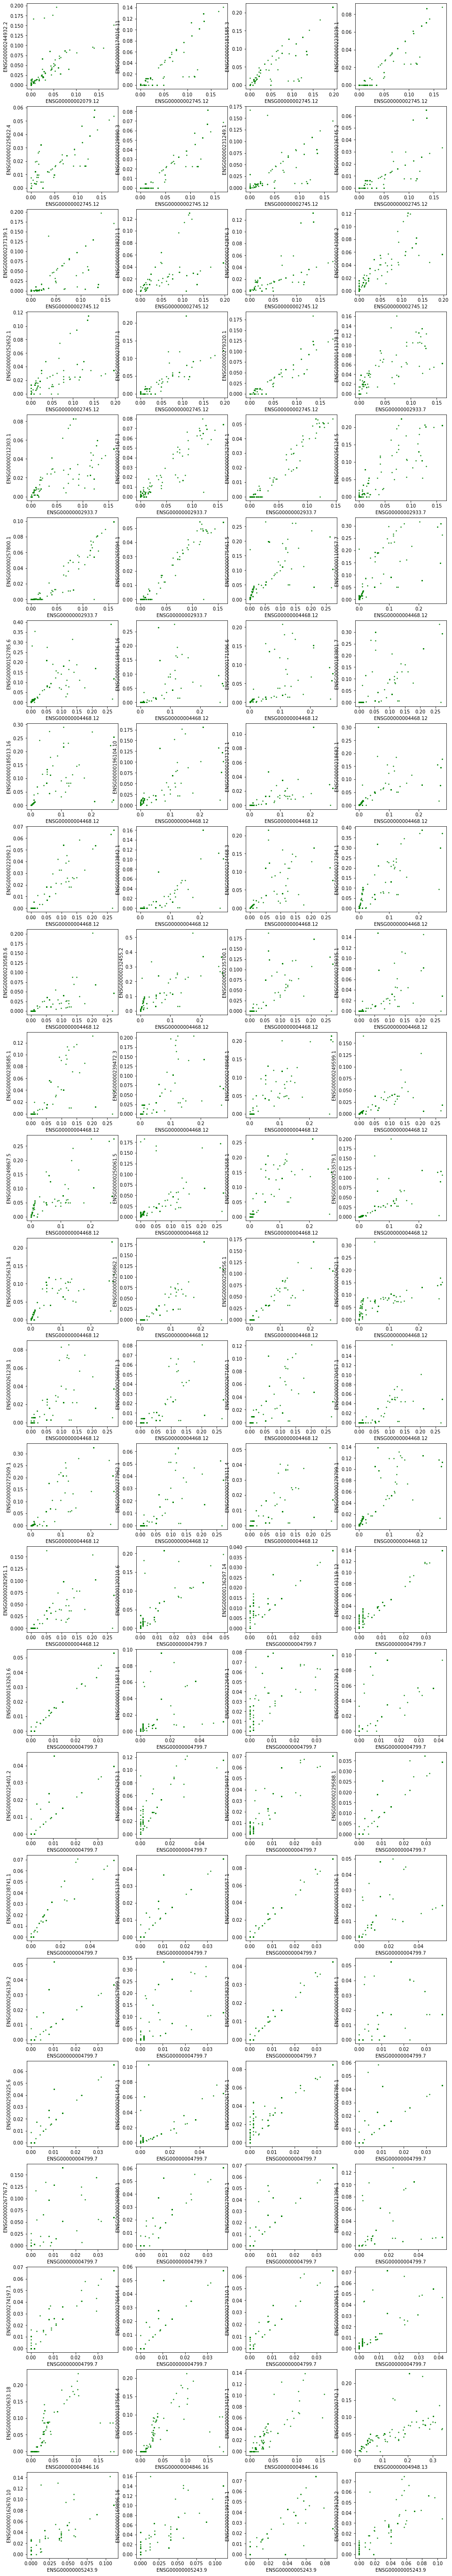

In [6]:
NROW, NCOL, SIZE = 25, 4, 4
nplots = NROW * NCOL

_, axes = plt.subplots(NROW, NCOL, figsize = (NCOL * SIZE, NROW * SIZE))
axes = axes.ravel()
for ax, (row_idx, col_idx) in zip(axes, filtered_indices[:nplots]):
    count_x_all, count_y_all = h9_tpm.iloc[row_idx], h9_tpm.iloc[col_idx]
    # remove outliers
    count_x, count_y = remove_outliers_2d(count_x_all, count_y_all)
    # Undo log-scale
    count_x, count_y = np.exp(count_x) - 1, np.exp(count_y) - 1
    # plot
    ax.scatter(count_x, count_y, s = 2, c = 'g')
    ax.set_xlabel(h9_tpm.index.values[row_idx])
    ax.set_ylabel(h9_tpm.index.values[col_idx])

Definitely this is not ready for a fitting yet. We need to find some nice algorithm to detect and rule out the outliers. Notice even after outlier removal, most gene pairs do not look like "logic gates". The selection of logic gates suppose to be rare

## Fitting

The first thing to do is to do a speed test (also a sanity test since the package is not in use for months)

Best model keywords: ['Michaelis_Menten', 'Basal_expression', 'Activation']
Best model AIC: -1045.6745570636224
Best model parameters: {'alpha': 0.1909013696684333, 'b': 0.0052501447559435265, 'K': 0.1294729561636342}
Best model expression: (A*alpha + K*b)/(A + K)
Time elapse: 3.7489547729492188


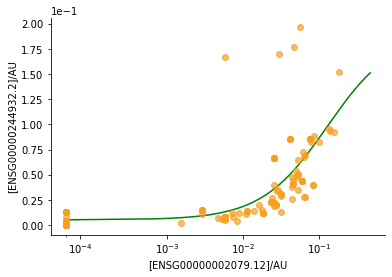

Comparing to not removing outliers
Best model keywords: ['Linear']
Best model AIC: -490.5784136008302
Best model parameters: {'alpha': 0.11581251069442418, 'b': 0.06539136924107253}
Best model expression: A*alpha + b
Time elapse: 4.87529730796814


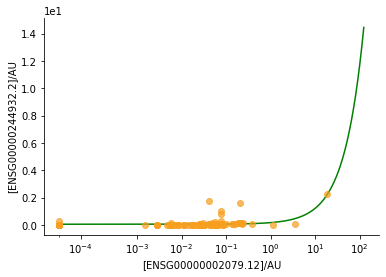

In [7]:
# Pick the first filtered gene pair
count_inducer_all = np.array(h9_tpm.iloc[filtered_indices[0][0]])
count_reporter_all = np.array(h9_tpm.iloc[filtered_indices[0][1]])
count_inducer, count_reporter = remove_outliers_2d(count_inducer_all, count_reporter_all)
count_inducer, count_reporter = np.exp(count_inducer) - 1, np.exp(count_reporter) - 1
count_inducer = count_inducer.reshape(-1, 1)

inducer_name = h9_tpm.index.values[filtered_indices[0][0]]
reporter_name = h9_tpm.index.values[filtered_indices[0][1]]

start_time = time.time()
best_model, all_models = selectModel(count_inducer,
                        count_reporter,
                        None,
                        modelSolver = ModelSolver.SLSQP,
                        modelSet = ModelSet.Activation_System,
                        parallel = False)
elapsed = time.time() - start_time
best_model_specs = [spec.name for spec in best_model.modelSpecs]
print("Best model keywords:", best_model_specs)
print("Best model AIC:", best_model.IC)
print("Best model parameters:", 
    {key: val for key, val in zip(best_model.thetaKey, best_model.thetaVal)})
print("Best model expression:", best_model.expression)
print("Time elapse:", elapsed)

plotHelper(count_inducer, count_reporter, best_model,
        inducer_name = inducer_name, reporter_name = reporter_name,
        markersize = 6)

# not removing outliers
count_inducer_all, count_reporter_all = np.exp(count_inducer_all) - 1, np.exp(count_reporter_all) - 1
count_inducer_all = count_inducer_all.reshape(-1, 1)
start_time = time.time()
best_model, all_models = selectModel(count_inducer_all,
                        count_reporter_all,
                        None,
                        modelSolver = ModelSolver.SLSQP,
                        modelSet = ModelSet.Activation_System,
                        parallel = False)
elapsed = time.time() - start_time
best_model_specs = [spec.name for spec in best_model.modelSpecs]
print("Comparing to not removing outliers")
print("Best model keywords:", best_model_specs)
print("Best model AIC:", best_model.IC)
print("Best model parameters:", 
    {key: val for key, val in zip(best_model.thetaKey, best_model.thetaVal)})
print("Best model expression:", best_model.expression)
print("Time elapse:", elapsed)

plotHelper(count_inducer_all, count_reporter_all, best_model,
        inducer_name = inducer_name, reporter_name = reporter_name,
        markersize = 6)

It's time to scale up. Let's see what the first 100 fitting look like

Pair No. 1
Best model keywords: ['Michaelis_Menten', 'Basal_expression', 'Activation']
Best model AIC: -1045.6745570636224
Best model parameters: {'alpha': 0.1909013696684333, 'b': 0.0052501447559435265, 'K': 0.1294729561636342}
Time elapse: 3.1981470584869385
Pair No. 2
Best model keywords: ['Hill', 'No_basal_expression', 'Activation']
Best model AIC: -1155.1393992203057
Best model parameters: {'alpha': 0.34943348469667546, 'K': 0.23787507533881602, 'n': 1.63145386215702}
Time elapse: 3.5233874320983887
Pair No. 3
Best model keywords: ['Quadratic', 'Basal_expression', 'Inducer_Michaelis_Menten', 'Repression', 'Inducer_Repression', 'Inducer']
Best model AIC: -1118.998359788083
Best model parameters: {'alpha': -0.050856689567523504, 'b': 1.1354304318183976, 'K': 0.22036718537809113, 'K_I': 0.15609150044959313}
Time elapse: 4.174492597579956
Pair No. 4
Best model keywords: ['Hill', 'No_basal_expression', 'Activation']
Best model AIC: -1376.5736570148626
Best model parameters: {'alpha': 0

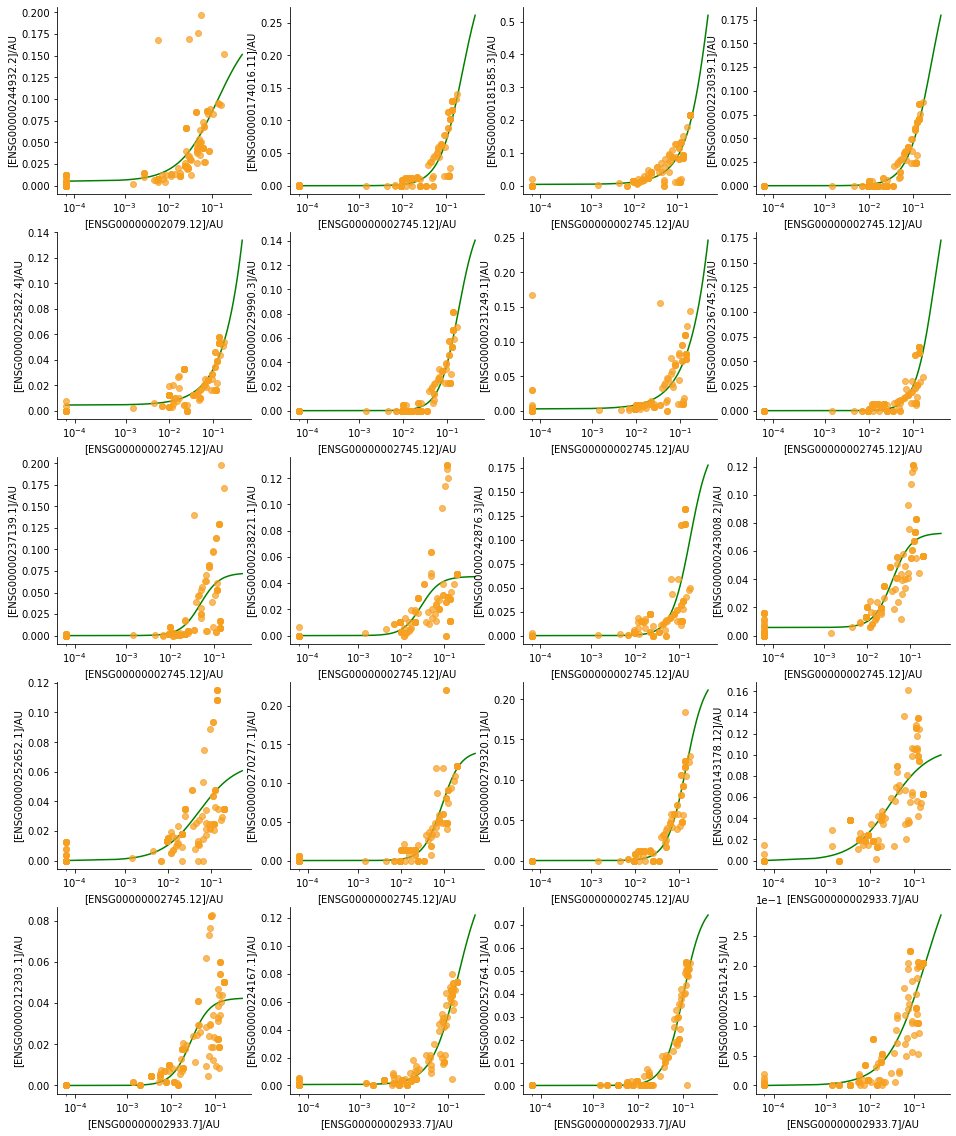

In [8]:
NROW, NCOL, SIZE = 25, 4, 4
nplots = NROW * NCOL

_, axes = plt.subplots(NROW, NCOL, figsize = (NCOL * SIZE, NROW * SIZE))
axes = axes.ravel()

i = 1
for ax, (row_idx, col_idx) in zip(axes, filtered_indices[:nplots]):
    count_x_all, count_y_all = np.array(h9_tpm.iloc[row_idx]), np.array(h9_tpm.iloc[col_idx])
    # remove outliers
    count_x, count_y = remove_outliers_2d(count_x_all, count_y_all)
    # Undo log-scale
    count_x, count_y = np.exp(count_x) - 1, np.exp(count_y) - 1
    count_x = count_x.reshape(-1, 1)
    # fitting
    start_time = time.time()
    best_model, all_models = selectModel(count_x,
                            count_y,
                            modelSolver = ModelSolver.SLSQP,
                            modelSet = ModelSet.Activation_System,
                            parallel = False)
    elapsed = time.time() - start_time
    best_model_specs = [spec.name for spec in best_model.modelSpecs]
    print("Pair No.", i)
    print("Best model keywords:", best_model_specs)
    print("Best model AIC:", best_model.IC)
    print("Best model parameters:", 
          {key: val for key, val in zip(best_model.thetaKey, best_model.thetaVal)})
    print("Time elapse:", elapsed)
    
    inducer_name = h9_tpm.index.values[row_idx]
    reporter_name = h9_tpm.index.values[col_idx]
    plotHelper(count_x, count_y, best_model,
            inducer_name = inducer_name, reporter_name = reporter_name,
            ax = ax,
            logScale = True,
            markersize = 6)
    i += 1